In [1]:
!pip install -U gensim
!pip install pyLDAvis

import json, os
import pandas as pd
import nltk
import glob
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
nltk.download('punkt')

# regular expression library
import re
# wordcloud library
from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('dutch')

import gensim.corpora as corpora

import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 24.1 MB 98.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3b4bb9435aedc01e59b0f7b40d3f62c04d3566d93db13d1ca52b1f83940feadc
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
path_ftm = 'gdrive/MyDrive/CS/Thesis/rc_testdata/ftm-nl.article-cleansed-1000-articles.json'
path_joop = 'gdrive/MyDrive/CS/Thesis/rc_testdata/joop-bnnvara-nl.article-cleansed-1000-articles.json'
path_nos = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nos-nl.article-cleansed-1000-articles.json'
path_nu = 'gdrive/MyDrive/CS/Thesis/rc_testdata/nu-nl.article-cleansed-1000-articles.json'
path_volkskrant = 'gdrive/MyDrive/CS/Thesis/rc_testdata/volkskrant-nl.article-cleansed-1000-articles.json'

In [4]:
df_ftm = pd.read_json(path_ftm)
df_joop = pd.read_json(path_joop)
df_nos = pd.read_json(path_nos)
df_nu = pd.read_json(path_nu)
df_volkskrant = pd.read_json(path_volkskrant)

In [5]:
df_ftm["Bron"] = "Follow The Money"
df_joop["Bron"] = "Joop"
df_nos["Bron"] = "NOS"
df_nu["Bron"] = "Nu"
df_volkskrant["Bron"] = "Volkskrant"

dfs = [df_joop, df_ftm, df_nos, df_nu, df_volkskrant]
df_all = pd.concat(dfs, ignore_index=True)

df_all.head()

,categories,cleaned,cleantext,id,keywords,leading-image,leading-image-caption-content,leading-image-caption-source,leading-image-copyright,og-description,og-image,og-title,structure,timestamp,title,url,Bron,html_raw,page_json
0,Video,2019-04-21T11:10:19.878000,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,159241,"[Brexit, Buitenhof, Europa, Europese Unie, Fra...",NaN,,,,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,https://joop.bnnvara.nl/content/uploads/2019/0...,Frans Timmermans: de staat van Europa na weer ...,"\n\t\t<p>Hoe staat Europa ervoor na <a href=""h...",2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,https://joop.bnnvara.nl/videos/frans-timmerman...,Joop,NaN,NaN
1,Opinie,2019-04-21T11:10:19.381000,In Frankrijk is ophef ontstaan rond kritiek op...,159237,"[Frankrijk, Hervé di Rosa, Kunst, Racisme, Ste...",NaN,,,,Niemand mag in een vrije maatschappij de macht...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Han van der Horst: Zijn die werken van ...,\n \n\t\t<p>In Frankrijk is ophef ontst...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,https://joop.bnnvara.nl/opinies/zijn-die-werke...,Joop,NaN,NaN
2,Nieuws,2019-04-21T11:10:18.678000,Twee Franse academici zijn een petitie begonne...,159213,"[Afrika, Frankrijk, Kolonialisme, Racisme]",NaN,,,,Twee Franse academici zijn een petitie begonne...,https://joop.bnnvara.nl/content/uploads/2019/0...,Academici willen racistische muurschildering u...,\n ...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,https://joop.bnnvara.nl/nieuws/academici-wille...,Joop,NaN,NaN
3,Opinie,2019-04-21T11:10:17.576000,Foto: ANP | Sander Koning Het was afgelopen ma...,159230,"[Forum voor Democratie, GroenLinks, Jesse Klav...",NaN,,,,GroenLinks moet oppassen dat ze niet voor lang...,https://joop.bnnvara.nl/content/uploads/2019/0...,Opinie Joost van Spanje: Weglopen van de wegloper,"\n \n\t\t<figure id=""attachment_159231""...",2019-04-14 09:12:48,Weglopen van de wegloper,https://joop.bnnvara.nl/opinies/weglopen-van-d...,Joop,NaN,NaN
4,Nieuws,2019-04-21T11:10:16.926000,Op 2 april 2019 was de opening van de Vrijheid...,159226,"[Jonathan Holslag, Vrijheid, Vrijheidscolleges]",NaN,,,,Op 2 april 2019 was de opening van de Vrijheid...,https://joop.bnnvara.nl/content/uploads/2019/0...,Vrijheidscollege Jonathan Holslag: &#039;Strij...,\n ...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,https://joop.bnnvara.nl/nieuws/vrijheidscolleg...,Joop,NaN,NaN


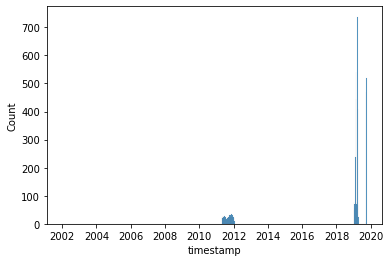

In [6]:
sns.histplot(data=df_all, x='timestamp')

In [7]:
# Remove the columns
articles = df_all.drop(columns=['id', 'keywords',
                                'leading-image', 'leading-image-caption-content',
                                'leading-image-caption-source', 'leading-image-copyright',
                                'og-description', 'og-image', 'og-title',
                                'structure', 'url', 'html_raw', 'page_json',
                                'categories', 'cleaned'], axis=1)# Print out the first rows of papers
articles.head()

,cleantext,timestamp,title,Bron
0,Hoe staat Europa ervoor na w&eacute;&eacute;r ...,2019-04-14 13:51:58,Frans Timmermans: de staat van Europa na weer ...,Joop
1,In Frankrijk is ophef ontstaan rond kritiek op...,2019-04-14 12:41:28,Zijn die werken van Hervé di Rosa wel zo racis...,Joop
2,Twee Franse academici zijn een petitie begonne...,2019-04-14 09:56:04,Academici willen racistische muurschildering u...,Joop
3,Foto: ANP | Sander Koning Het was afgelopen ma...,2019-04-14 09:12:48,Weglopen van de wegloper,Joop
4,Op 2 april 2019 was de opening van de Vrijheid...,2019-04-14 09:01:51,Vrijheidscollege Jonathan Holslag: &#8216;Stri...,Joop


In [8]:
# Remove punctuation
articles['cleantext_processed'] = \
articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
articles['cleantext_processed'] = \
articles['cleantext_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
articles['cleantext_processed'].head()

<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<input>:2: DeprecationWarning: invalid escape sequence \.
<ipython-input-8-341723ed8bf8>:2: DeprecationWarning: invalid escape sequence \.
  articles['cleantext_processed'] = articles['cleantext'].map(lambda x: re.sub('[,\.!?]', '', x))


0    hoe staat europa ervoor na w&eacute;&eacute;r ...
1    in frankrijk is ophef ontstaan rond kritiek op...
2    twee franse academici zijn een petitie begonne...
3    foto: anp | sander koning het was afgelopen ma...
4    op 2 april 2019 was de opening van de vrijheid...
Name: cleantext_processed, dtype: object

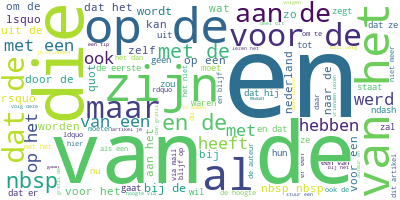

In [9]:
# Join the different processed titles together.
long_string = ','.join(list(articles['cleantext_processed'].values))# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [10]:
stop_words.extend(['nbsp', 'rsquo', 'lsquo','euml', 'rdquo', 'quot', 'ldquo' ])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = articles.cleantext_processed.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['staat', 'europa', 'ervoor', 'eacute', 'eacute', 'brexit', 'uitstel', 'vooravond', 'europese', 'verkiezingen', 'vanwege', 'uitstel', 'verenigd', 'koninkrijk', 'verplicht', 'mee', 'verkiezingen', 'betekent', 'verhoudingen', 'europees', 'parlement', 'ondanks', 'puinhoop', 'onzekerheid', 'naderende', 'brexit', 'verenigd', 'koninkrijk', 'meebrengt', 'klinkt']


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 2), (5, 2), (6, 5), (7, 2), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 3), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [26]:
# number of topics
num_topics = 7
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
doc_lda = lda_model[corpus]

In [27]:
# Print the Keyword in the 10 topics
lda_model.show_topics()

[(0,
  '0.005*"we" + 0.004*"jaar" + 0.003*"wel" + 0.003*"gaat" + 0.003*"twee" + 0.002*"weer" + 0.002*"waar" + 0.002*"gaan" + 0.002*"beeld" + 0.002*"zegt"'),
 (1,
  '0.005*"jaar" + 0.005*"we" + 0.004*"wel" + 0.003*"beeld" + 0.003*"mensen" + 0.003*"gaat" + 0.003*"twee" + 0.002*"zegt" + 0.002*"nieuwe" + 0.002*"gaan"'),
 (2,
  '0.005*"we" + 0.004*"jaar" + 0.004*"wel" + 0.003*"beeld" + 0.003*"nederland" + 0.003*"gaan" + 0.002*"gaat" + 0.002*"twee" + 0.002*"mensen" + 0.002*"zegt"'),
 (3,
  '0.005*"jaar" + 0.004*"we" + 0.003*"wel" + 0.003*"beeld" + 0.003*"gaat" + 0.003*"volgens" + 0.003*"zegt" + 0.003*"waar" + 0.003*"moeten" + 0.002*"nederland"'),
 (4,
  '0.005*"we" + 0.005*"wel" + 0.004*"jaar" + 0.003*"beeld" + 0.003*"maken" + 0.003*"mensen" + 0.003*"zegt" + 0.002*"waar" + 0.002*"gaat" + 0.002*"alleen"'),
 (5,
  '0.006*"we" + 0.005*"jaar" + 0.004*"wel" + 0.003*"mensen" + 0.003*"beeld" + 0.003*"waar" + 0.003*"gaan" + 0.002*"weer" + 0.002*"gaat" + 0.002*"af"'),
 (6,
  '0.007*"we" + 0.004*"wel"

In [28]:
def terms_topics_frame(terms):

  df = pd.DataFrame(data=None)

  for t in terms:
    df_t_topics = pd.DataFrame(lda_model.get_term_topics(t, minimum_probability=0.000000001))
    df_t_topics = df_t_topics.drop(columns=0)
    df_t_topics = df_t_topics.rename(columns={1:t})
    df = pd.concat([df, df_t_topics], axis=1)
  
  return df


In [29]:
df_tt = terms_topics_frame(['vvd', 'pvv', 'fvd', 'pvda', 'sp', 'gl'])
df_tt['topic'] = df_tt.index
df_tt.head()

,vvd,pvv,fvd,pvda,sp,gl,topic
0,0.000319,0.000097,0.000065,0.000172,0.000099,0.000003,0
1,0.000429,0.000112,0.000039,0.000078,0.000109,0.000003,1
2,0.000263,0.000111,0.000042,0.000129,0.000145,0.000004,2
3,0.000333,0.000174,0.000046,0.000223,0.000139,0.000004,3
4,0.000330,0.000166,0.000053,0.000170,0.000098,0.000003,4


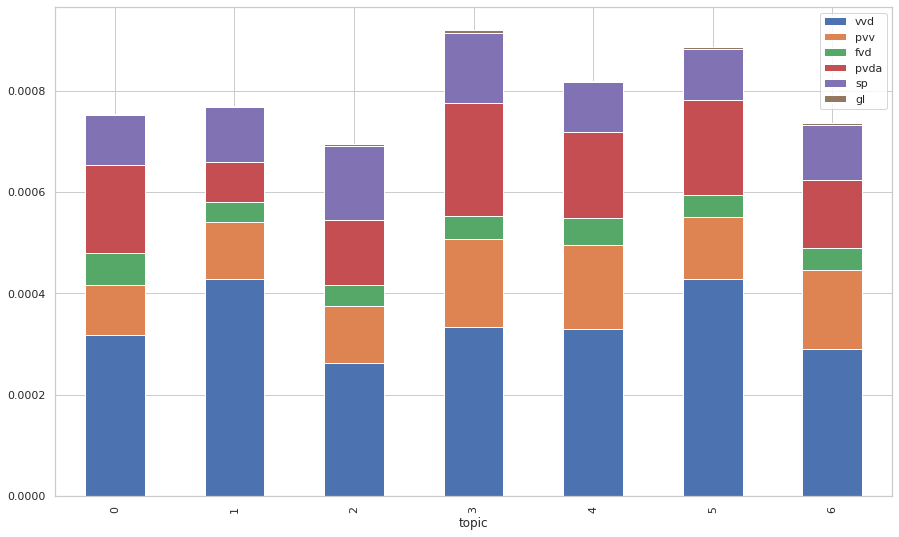

In [30]:
sns.set_theme(style="whitegrid")

# Plot the topic dist per term
df_tt.set_index('topic').plot(kind='bar', stacked=True)
sns.set(rc={'figure.figsize':(15,9)})

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.001454  0.005594       1        1  19.760531
1     -0.002566  0.006780       2        1  16.513235
3      0.012462 -0.002558       3        1  16.303508
5     -0.001900 -0.004437       4        1  13.845973
4     -0.001741 -0.004652       5        1  12.561598
2     -0.001714  0.004730       6        1  11.178531
6     -0.005995 -0.005458       7        1   9.836623, topic_info=       Term         Freq        Total Category  logprob  loglift
509      we  6408.000000  6408.000000  Default  30.0000  30.0000
423     wel  4685.000000  4685.000000  Default  29.0000  29.0000
276  mensen  3157.000000  3157.000000  Default  28.0000  28.0000
74     waar  3073.000000  3073.000000  Default  27.0000  27.0000
264   maken  2182.000000  2182.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
456  alleen   213.680678  2350.975290   Topic7  -6.3317  -0.0790
568    gaan   208.378449  2679.027568   Topic7  -6.3568  -0.2348
443    zien   177.760894  1934.376400   Topic7  -6.5157  -0.0680
17   eerste   174.864856  2202.971966   Topic7  -6.5321  -0.2145
0      alle   170.417162  1911.112171   Topic7  -6.5579  -0.0981

[616 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
739        1  0.213508      aantal
739        2  0.165528      aantal
739        3  0.157132      aantal
739        4  0.113951      aantal
739        5  0.115150      aantal
...      ...       ...         ...
22511      6  0.092524  zuidwesten
22511      7  0.046262  zuidwesten
18646      2  0.165005  zwerfafval
18646      5  0.660019  zwerfafval
18646      6  0.165005  zwerfafval

[1582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 6, 5, 3, 7])